# ***STOCK MARKET FORECASTING***

---



In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
df_exe=pd.read_excel("US30_tiny.xlsx")
print(df_exe.shape)
df_exe.head(5)

(10004, 8)


,Local time,Open,High,Low,Close,Volume,SMA7,SMA21
0,06.10.2019 07:20:00.000 GMT+0100,26557.169,26557.169,26557.169,26557.169,0.0,0.0,0.0
1,06.10.2019 07:25:00.000 GMT+0100,26557.169,26557.169,26557.169,26557.169,0.0,0.0,0.0
2,06.10.2019 07:30:00.000 GMT+0100,26557.169,26557.169,26557.169,26557.169,0.0,0.0,0.0
3,06.10.2019 07:35:00.000 GMT+0100,26557.169,26557.169,26557.169,26557.169,0.0,0.0,0.0
4,06.10.2019 07:40:00.000 GMT+0100,26557.169,26557.169,26557.169,26557.169,0.0,0.0,0.0


In [5]:
df1=df_exe.reset_index()['Close']

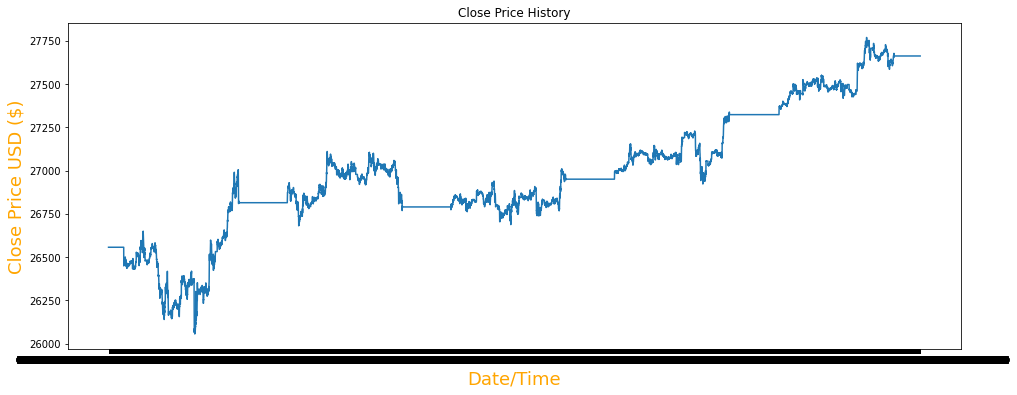

In [7]:
#Visualize the closing price history
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.xlabel('Date/Time',fontsize=18,color="orange")
plt.ylabel('Close Price USD ($)',fontsize=18,color="orange")
plt.plot(df_exe['Local time'],df_exe['Close'])

In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))    #df1 is the normalized value of 'Close' column
df1.shape

(10004, 1)

In [9]:
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
print(training_size,test_size)

8003 2001


In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [ ], [ ]
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Train on 7902 samples, validate on 1900 samples
Epoch 1/10
7902/7902 [==============================] - 97s 12ms/step - loss: 0.0088 - val_loss: 0.0011
Epoch 2/10
7902/7902 [==============================] - 95s 12ms/step - loss: 2.8899e-04 - val_loss: 5.5014e-04
Epoch 3/10
7902/7902 [==============================] - 93s 12ms/step - loss: 2.7418e-04 - val_loss: 5.1570e-04
Epoch 4/10
7902/7902 [==============================] - 95s 12ms/step - loss: 2.5293e-04 - val_loss: 2.1870e-04
Epoch 5/10
7902/7902 [==============================] - 93s 12ms/step - loss: 2.4422e-04 - val_loss: 1.0516e-04
Epoch 6/10
7902/7902 [==============================] - 93s 12ms/step - loss: 2.3848e-04 - val_loss: 1.7756e-04
Epoch 7/10
7902/7902 [==============================] - 94s 12ms/step - loss: 2.2170e-04 - val_loss: 2.0660e-04
Epoch 8/10
7902/7902 [==============================] - 94s 12ms/step - loss: 2.0160e-04 - val_loss: 1.1014e-04
Epoch 9/10
7902/7902 [==============================] - 95s 12ms

In [15]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [16]:
### Calculate RMSE performance metrics on train v/s predicted value:
math.sqrt(mean_squared_error(y_train,train_predict))

26856.495382765876

In [17]:
### Calculate RMSE performance metrics on test v/s predicted value:
math.sqrt(mean_squared_error(ytest,test_predict))

27538.383967808375

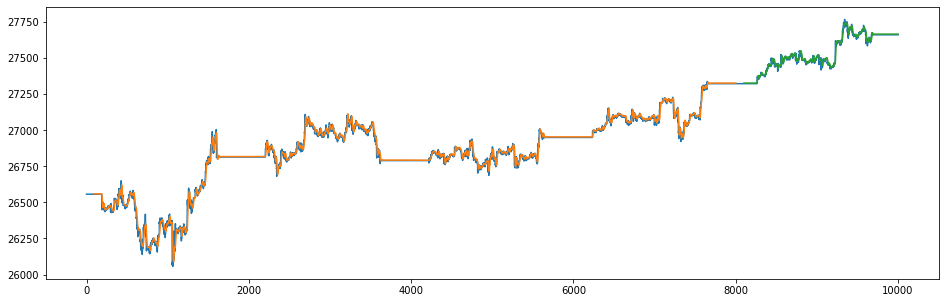

In [18]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict     #Orange graph
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict        #Green graph
# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(scaler.inverse_transform(df1))         #Original data: Blue graph
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [19]:
#last 100 points data is used everytime
i=test_data.size-100
x_input=test_data[i:].reshape(1,-1)      
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [22]:
#demonstrate prediction for next 36 points (3 hrs)
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<200):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)       #array that consists of the predicted values for the next 3hrs

[[0.9565145373344421], [0.9570063352584839], [0.957497775554657], [0.9579888582229614], [0.9584795832633972], [0.9589702486991882], [0.9594603776931763], [0.9599504470825195], [0.9604403972625732], [0.9609299898147583], [0.9614195823669434], [0.9619090557098389], [0.9623983502388], [0.9628874063491821], [0.9633764624595642], [0.9638653993606567], [0.9643543362617493], [0.9648432731628418], [0.96533203125], [0.9658207893371582], [0.9663095474243164], [0.9667981266975403], [0.9672866463661194], [0.9677752256393433], [0.9682639837265015], [0.9687522053718567], [0.969240665435791], [0.9697290062904358], [0.9702175259590149], [0.9707057476043701], [0.9711940288543701], [0.9716822504997253], [0.9721704721450806], [0.9726584553718567], [0.9731464385986328], [0.9736344814300537], [0.9741223454475403], [0.9746101498603821], [0.9750979542732239], [0.9755855202674866], [0.9760732054710388], [0.9765607714653015], [0.9770482182502747], [0.977535605430603], [0.9780228734016418], [0.9785100221633911]

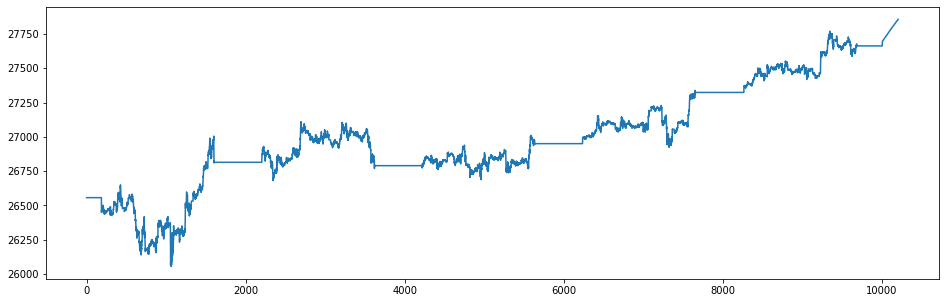

In [23]:
df3=df1.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()
plt.figure(figsize=(16,5))
plt.plot(df3)